In [1]:
import pygmt
import imageio
import xarray as xr
import numpy as np

# Plotting regional variables

Pick up a specific time step:

In [ ]:
step = 0

out = 'export/unconstrained/'
dataset = xr.open_dataset(out+'data'+str(step)+'Ma.nc')

### Elevation

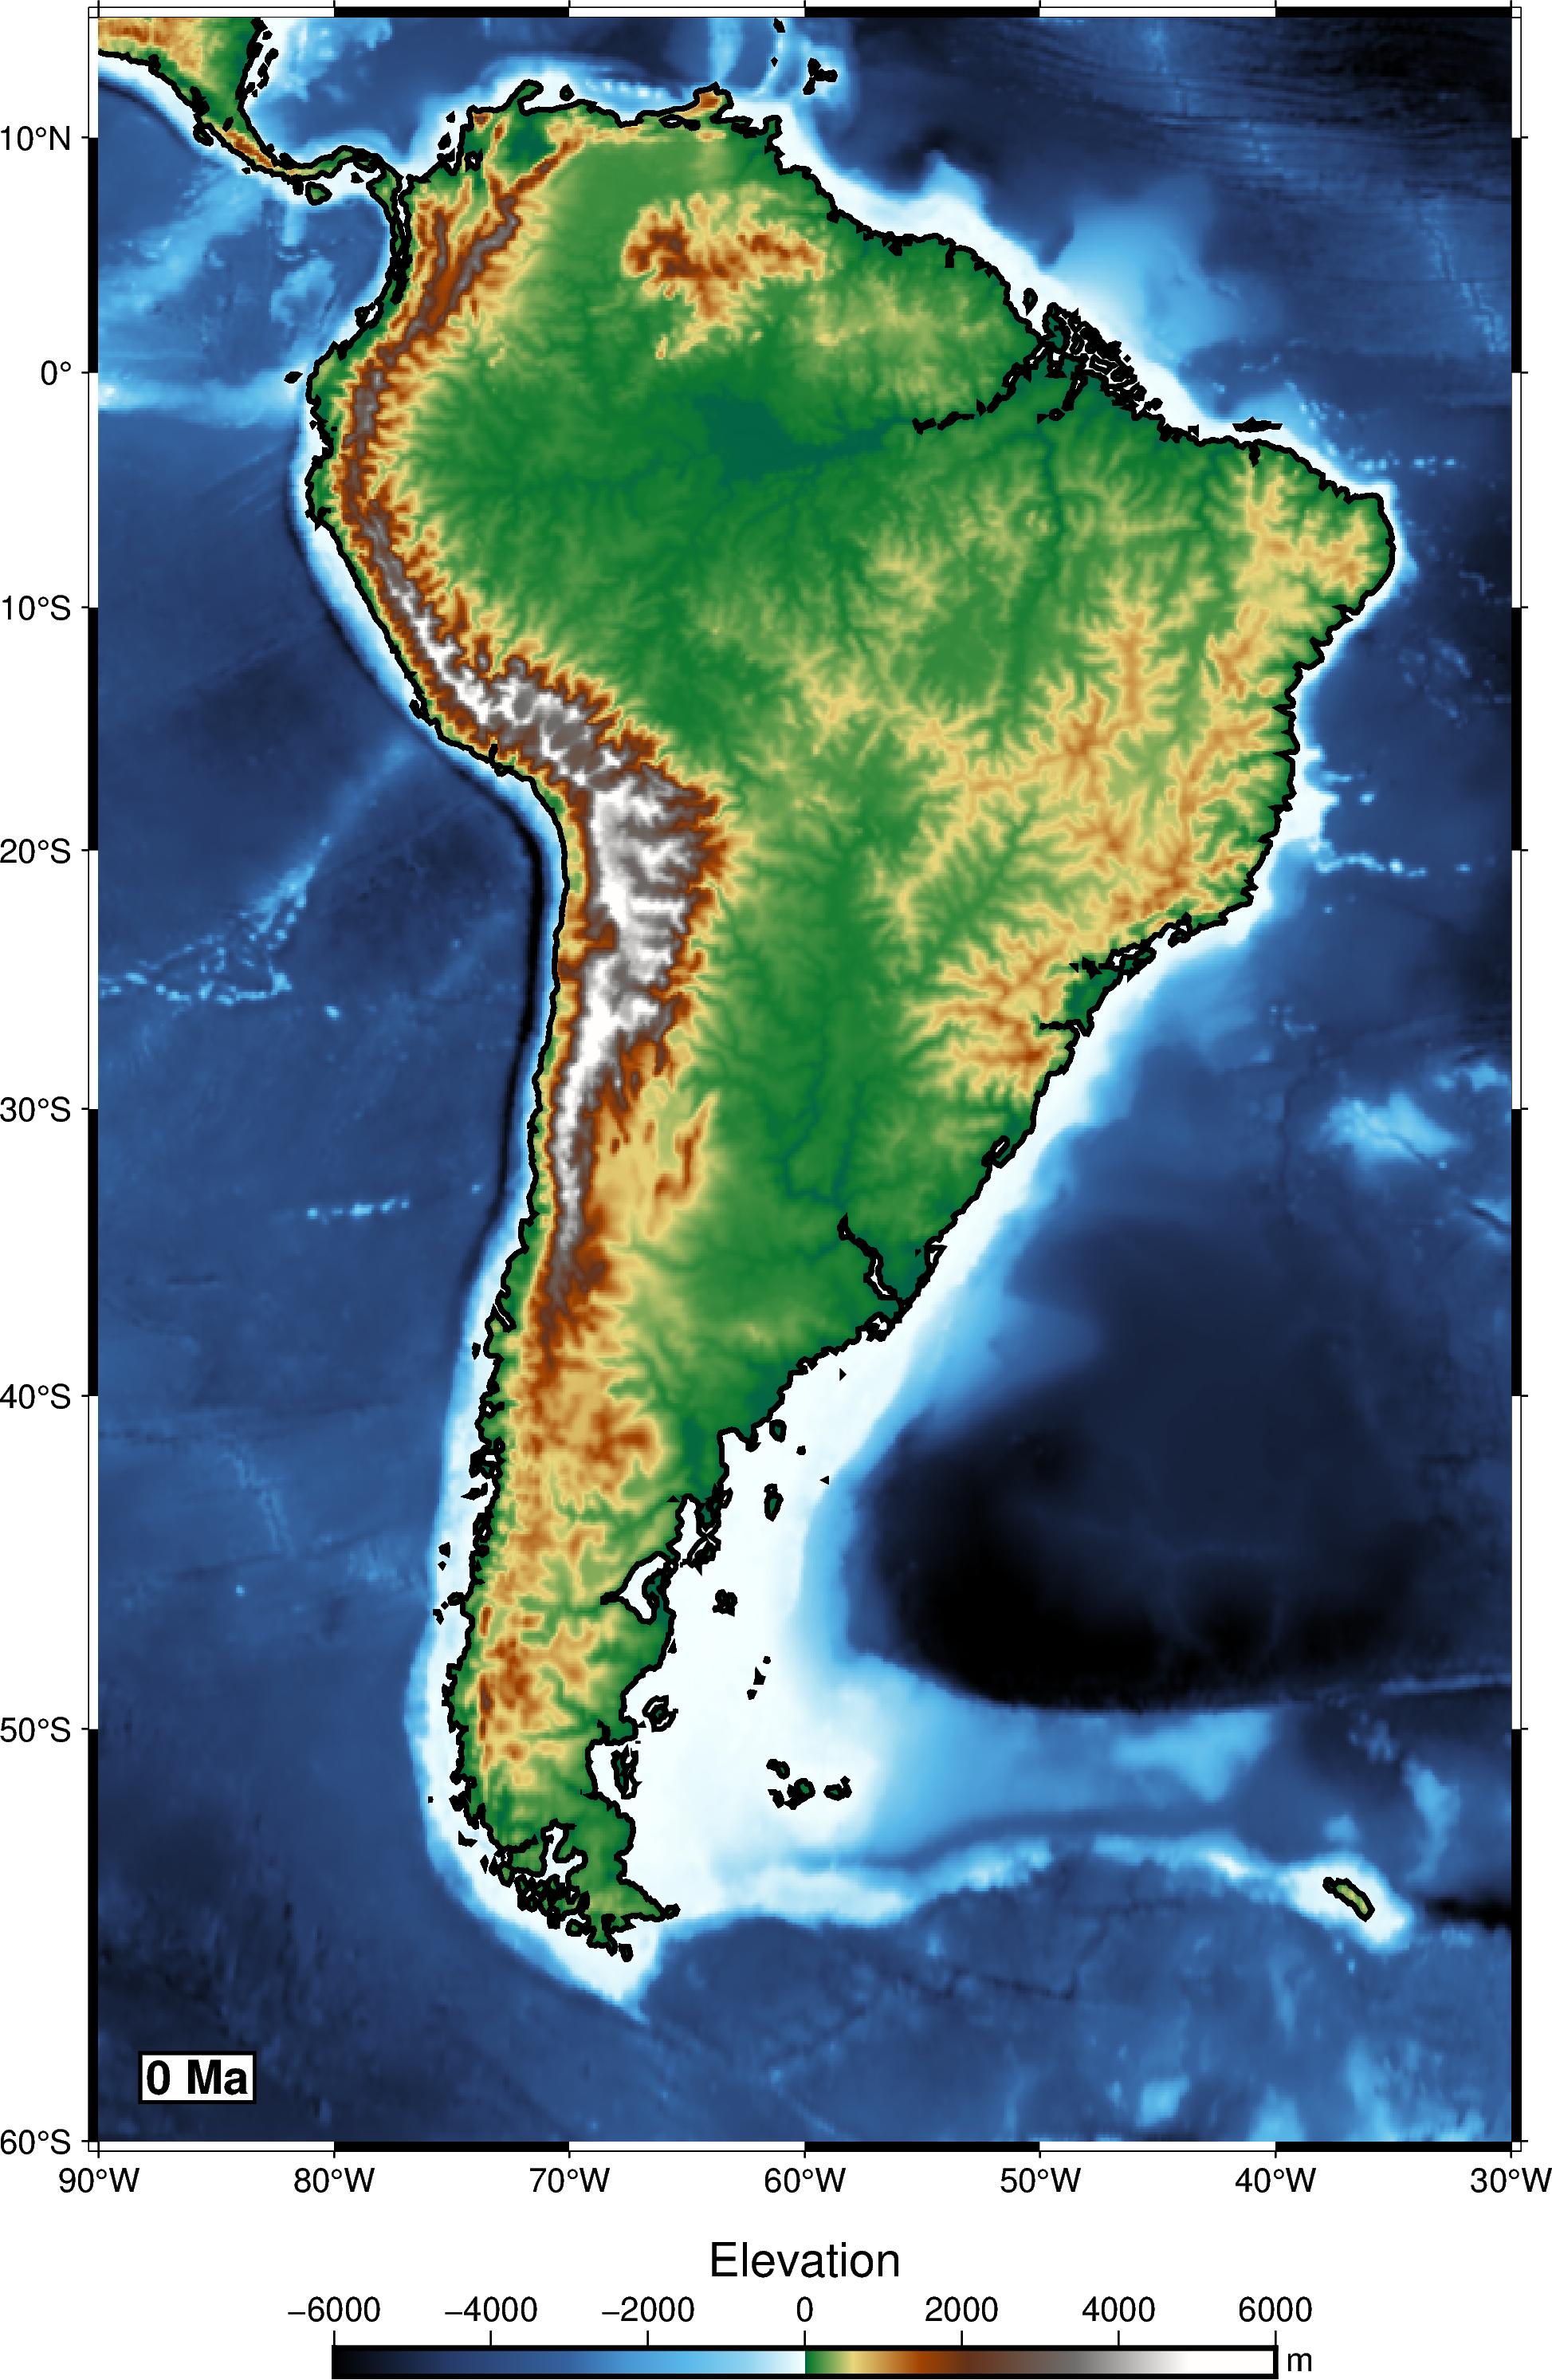

In [3]:
grid = dataset.elevation 

region = [-90,-30,-60,15]

fig = pygmt.Figure()

# Plotting elevation
with pygmt.config(FONT='10p,Helvetica,black'):
    
    pygmt.makecpt(cmap="geo", series=[-6000, 6000])
    
    fig.basemap(region=region, projection='M15c', frame='a')
    
    fig.grdimage(dataset.elevation, 
                 shading=False, 
                 frame=False)
    
    # Add contour
    fig.grdcontour(
        interval=0.1,
        grid=dataset.elevation,
        limit=[-0.1, 0.1],
        pen='1.5p'
    )

fig.colorbar(frame=["a2000", "x+lElevation", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")

# At time step
fig.text(text=str(step)+" Ma", position="BL", 
         fill='white', pen='1p', offset='0.5',
         font="14p,Helvetica-Bold,black",)

# Save name
# name = 'SAelev'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()#dpi=500, width=500)

### Erosion/deposition

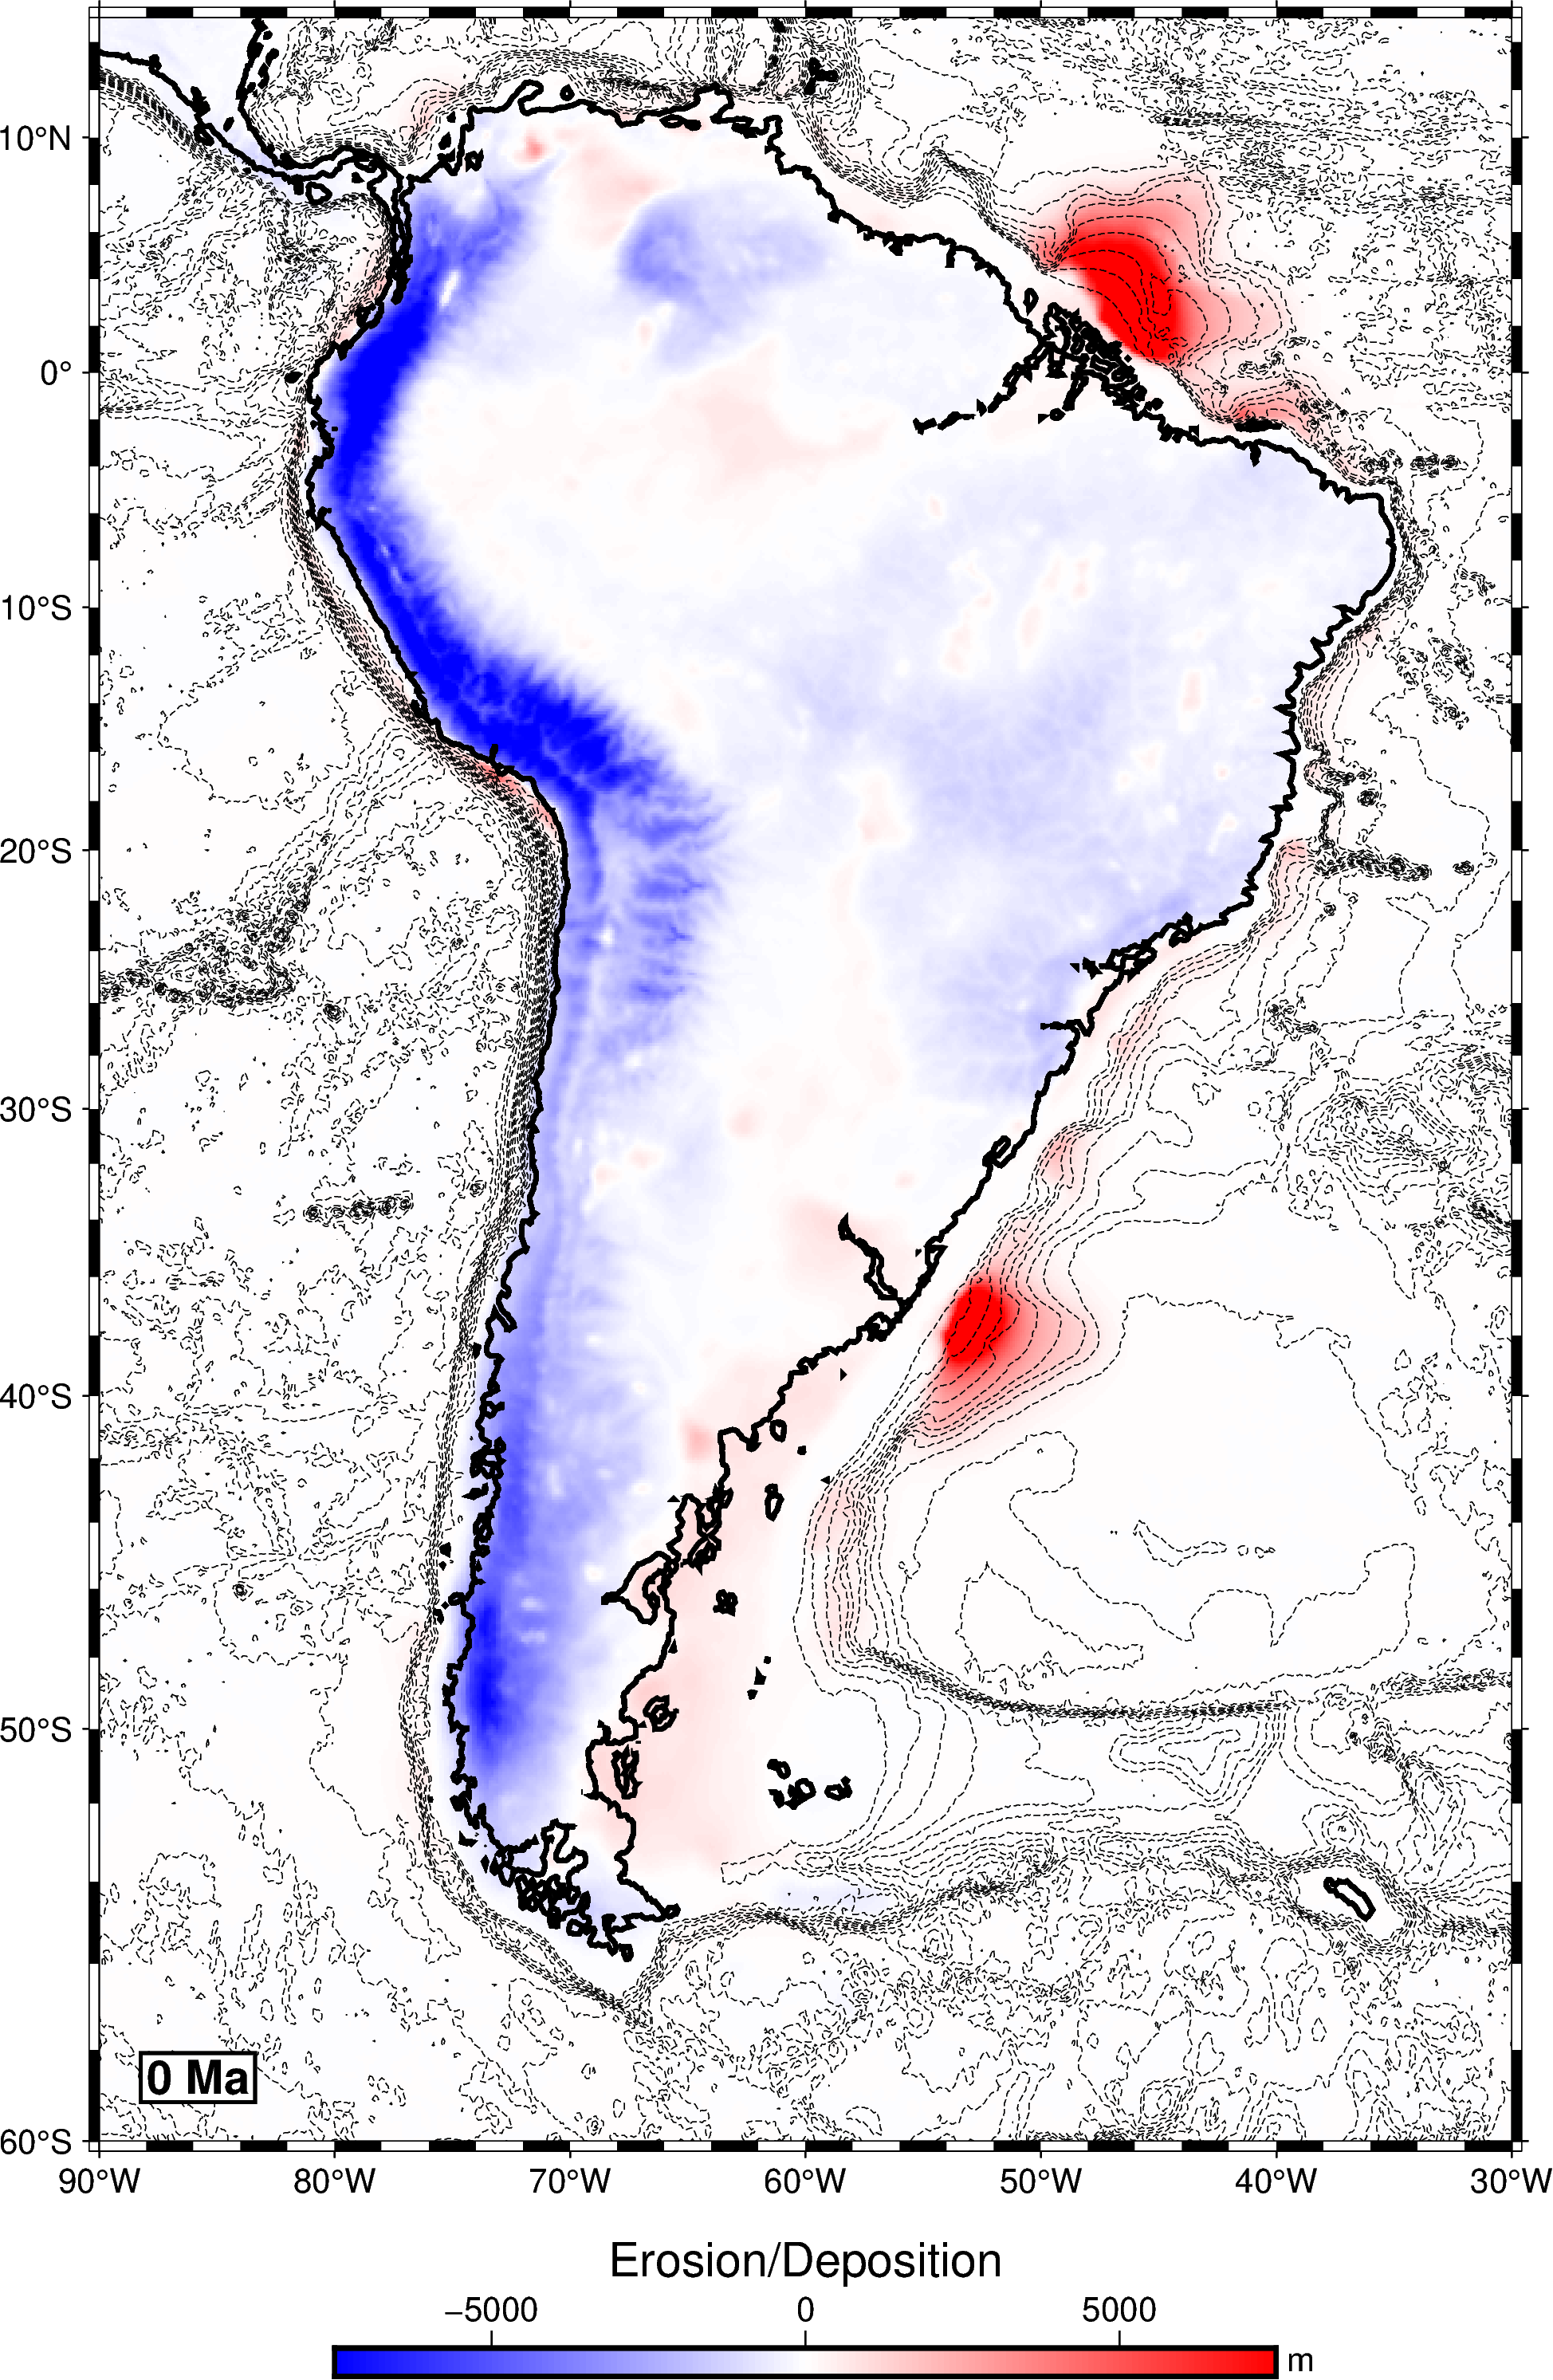

In [4]:
fig = pygmt.Figure()

with pygmt.config(COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
    pygmt.makecpt(
        cmap="polar", 
        series=[-7500,7500, 100],
    )

topo_data = pygmt.grdcut(
    grid,
    region=region,
)

proj='M15c'

fig.grdimage(dataset.erodep, 
             cmap=True,
             region=region,
             projection=proj,
             shading=False,
             frame=True,
            )

# Add contour
fig.grdcontour(
    interval=0.1,
    grid=dataset.elevation,
    region=region,
    projection=proj,
    limit=[-0.1, 0.1],
    pen = '1.5p'
)

# Add contour
fig.grdcontour(
    interval=500,
    grid=dataset.elevation,
    region=region,
    projection=proj,
    limit=[-10000, 0],
    pen = '0.25p,-'
)

fig.colorbar(frame=["a5000", "x+lErosion/Deposition", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

# At time step
fig.text(text=str(step)+" Ma", position="BL", 
         fill='white', pen='1p', offset='0.5',
         font="14p,Helvetica-Bold,black",)

# name = 'SAed'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()

### Discharge

In [5]:
# We will use a log scale here
vals = np.log10(dataset.fillDischarge)

# Let's look at the maximum log values (we will use it to set our colour bar in the figure below)
vals.max()

<xarray.DataArray 'fillDischarge' ()>
array(13.38423306)

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


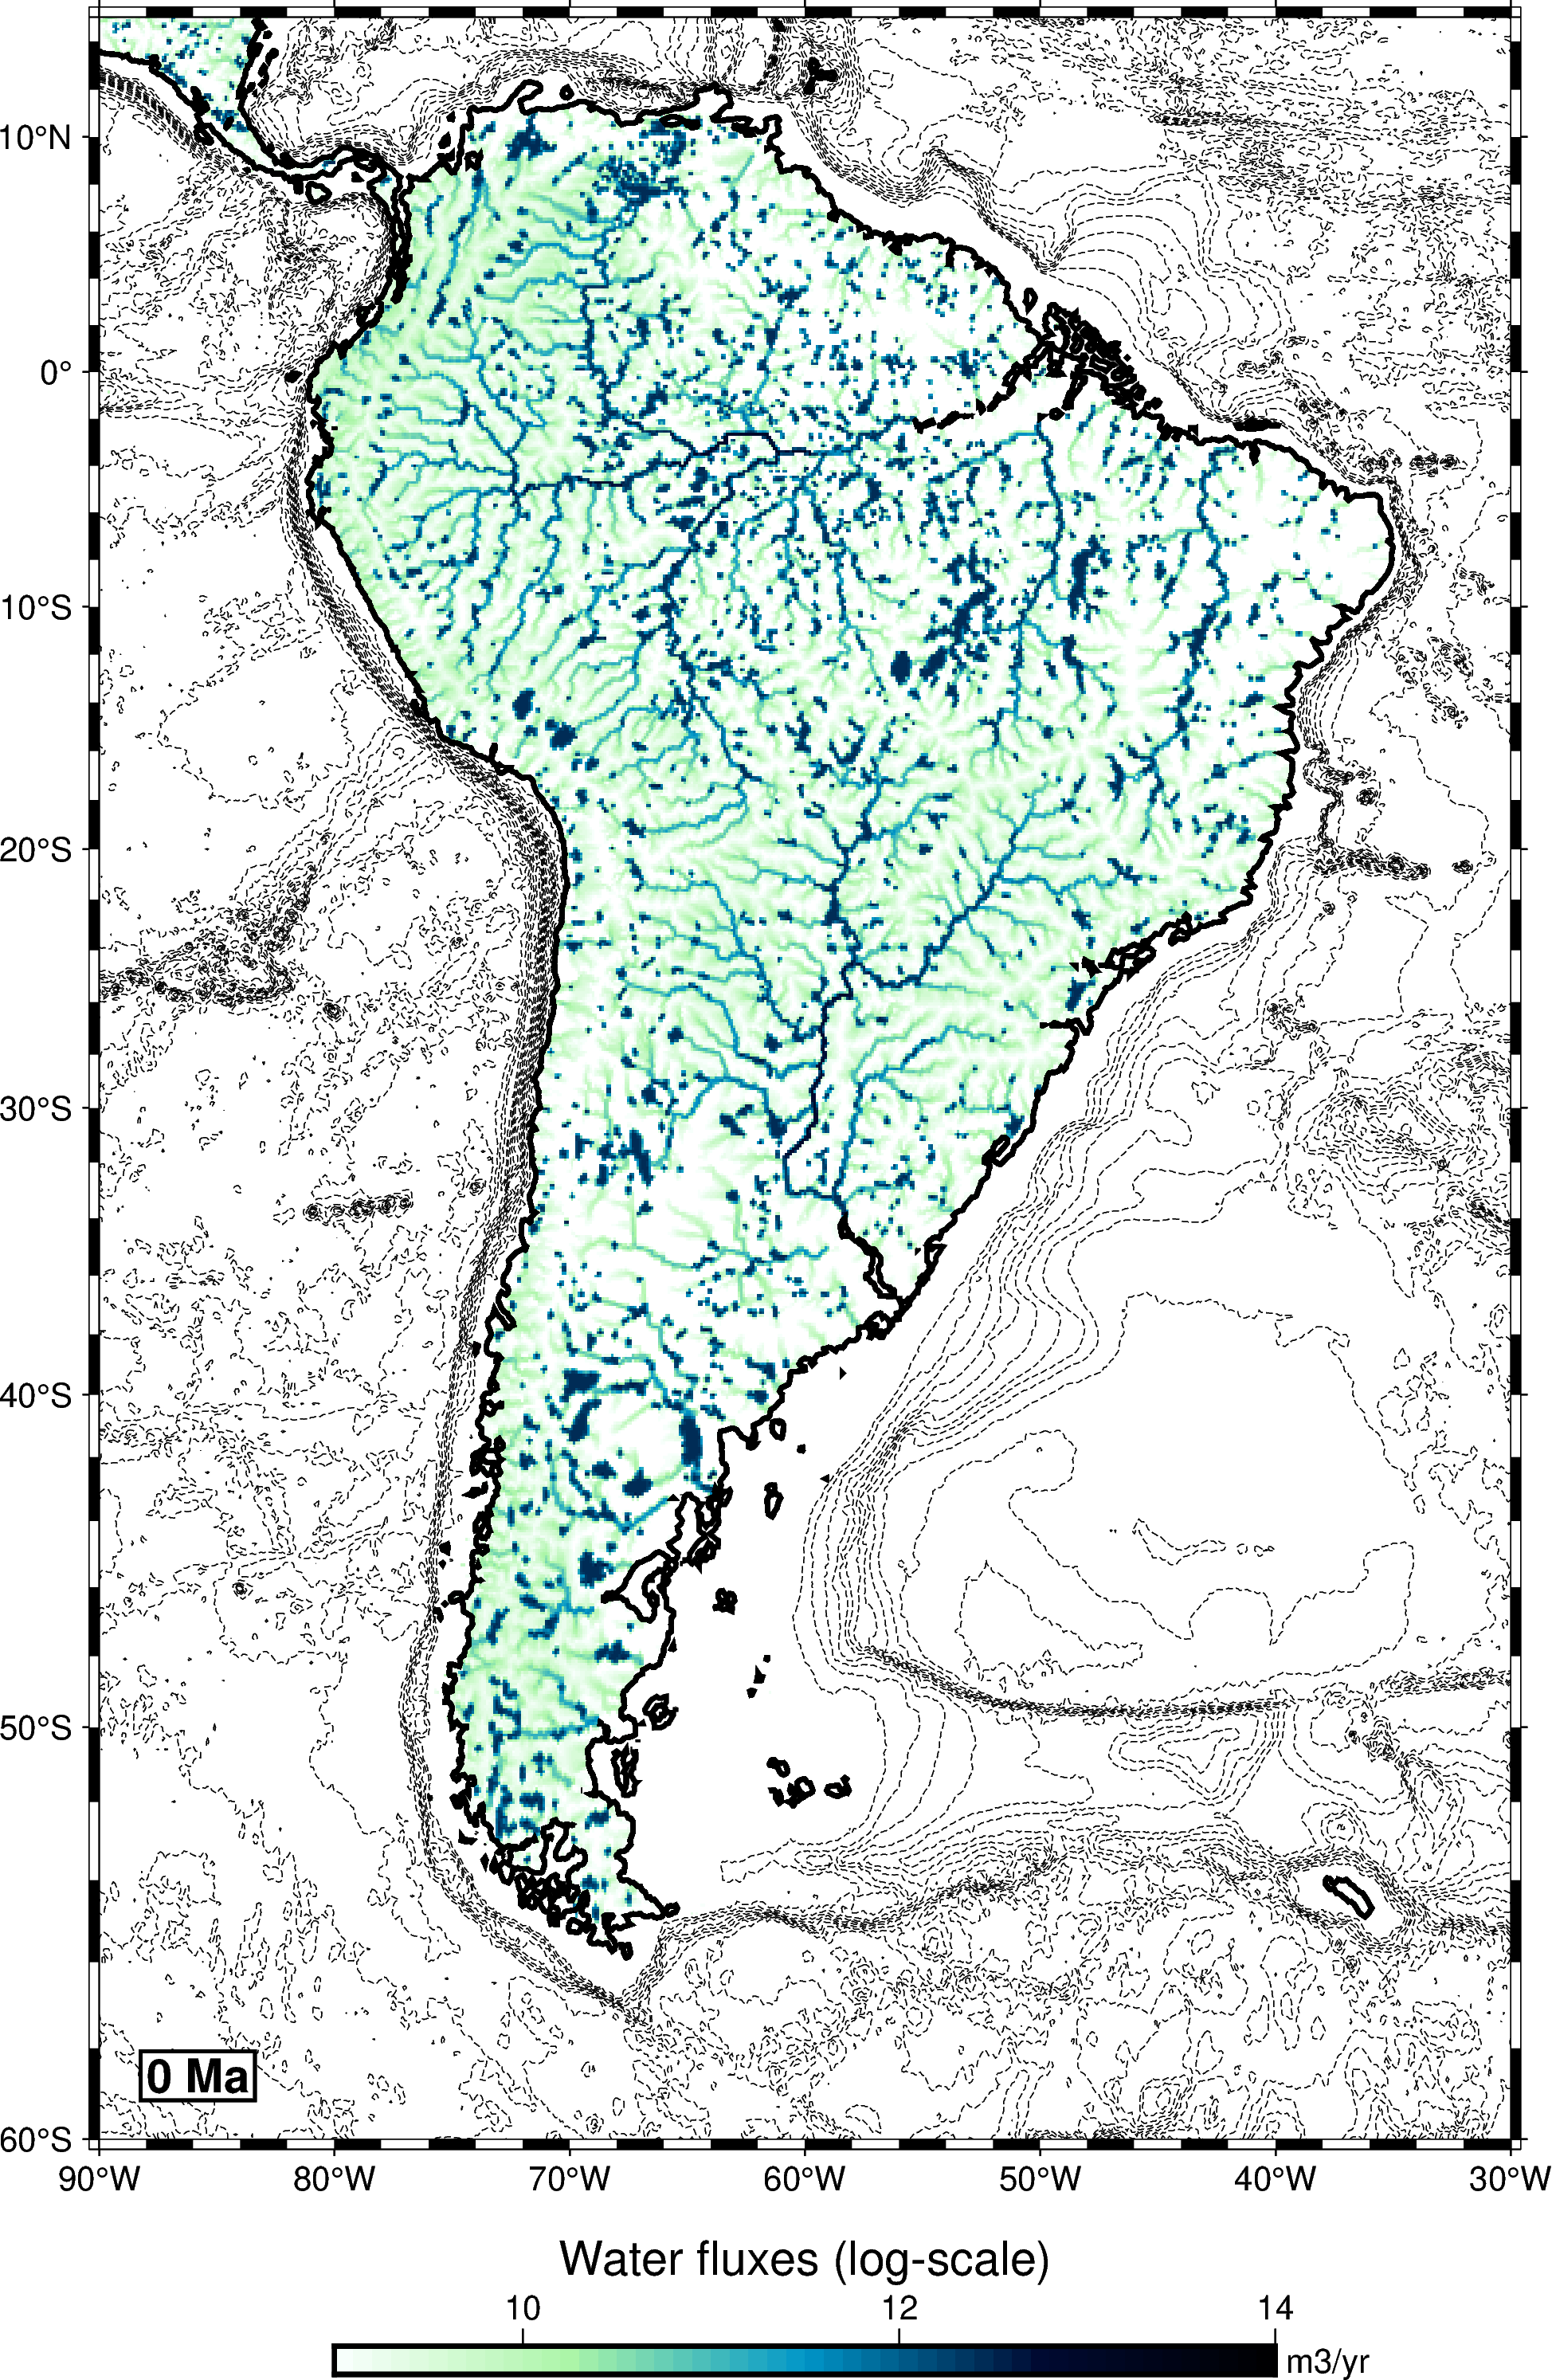

In [6]:
fig = pygmt.Figure()

with pygmt.config(COLOR_BACKGROUND="white"):
    pygmt.makecpt(
        cmap="ocean",
        series=[9,14,0.1],
        reverse=True,
    )

proj='M15c'

fig.grdimage(grid=vals, 
             cmap=True,
             region=region,
             projection=proj,
             shading=False,
             frame=True,
            )

# Add contour
fig.grdcontour(
    interval=0.1,
    grid=dataset.elevation,
    region=region,
    projection=proj,
    limit=[-0.1, 0.1],
    pen = '1.5p'
)

# Add contour
fig.grdcontour(
    interval=500,
    grid=dataset.elevation,
    region=region,
    projection=proj,
    limit=[-10000, 0],
    pen = '0.25p,-'
)

fig.colorbar(frame=["a2", 'x+l"Water fluxes (log-scale)"', "y+lm3/yr"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

# At time step
fig.text(text=str(step)+" Ma", position="BL", 
         fill='white', pen='1p', offset='0.5',
         font="14p,Helvetica-Bold,black",)

# name = 'SAfa'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()

### Basins

Clip the global dataset to the regional extent

In [7]:
mask_lon = (dataset.longitude >= region[0]) & (dataset.longitude <= region[1])
mask_lat = (dataset.latitude >= region[2]) & (dataset.latitude <= region[3])
clipds = dataset.where(mask_lon & mask_lat, drop=True)

Extract the number of unique basin indices in the clipped dataset

In [8]:
localbasins = clipds.basinID.values.astype(int)
uids = np.unique(localbasins)
localBasinNb = len(uids)
nids = np.arange(len(uids))

Replace basin indices with rearranged incremental indices for the region

In [9]:
mapIDs = np.zeros(localbasins.max()+1, dtype=int) 
mapIDs[uids] = nids
basinIDs = mapIDs[localbasins.flatten()].reshape(localbasins.shape)

In [10]:
dsBasin = xr.DataArray(
    data=basinIDs.astype(float),
    dims=["latitude", "longitude"],
    coords={
        "lat": clipds.latitude,
        "lon": clipds.longitude,
    },
)
ds_masked = dsBasin.where(dsBasin != 0.) 
clipds["newBasin"]=(['latitude', 'longitude'],  ds_masked.values)

In [11]:
localBasinNb

4179

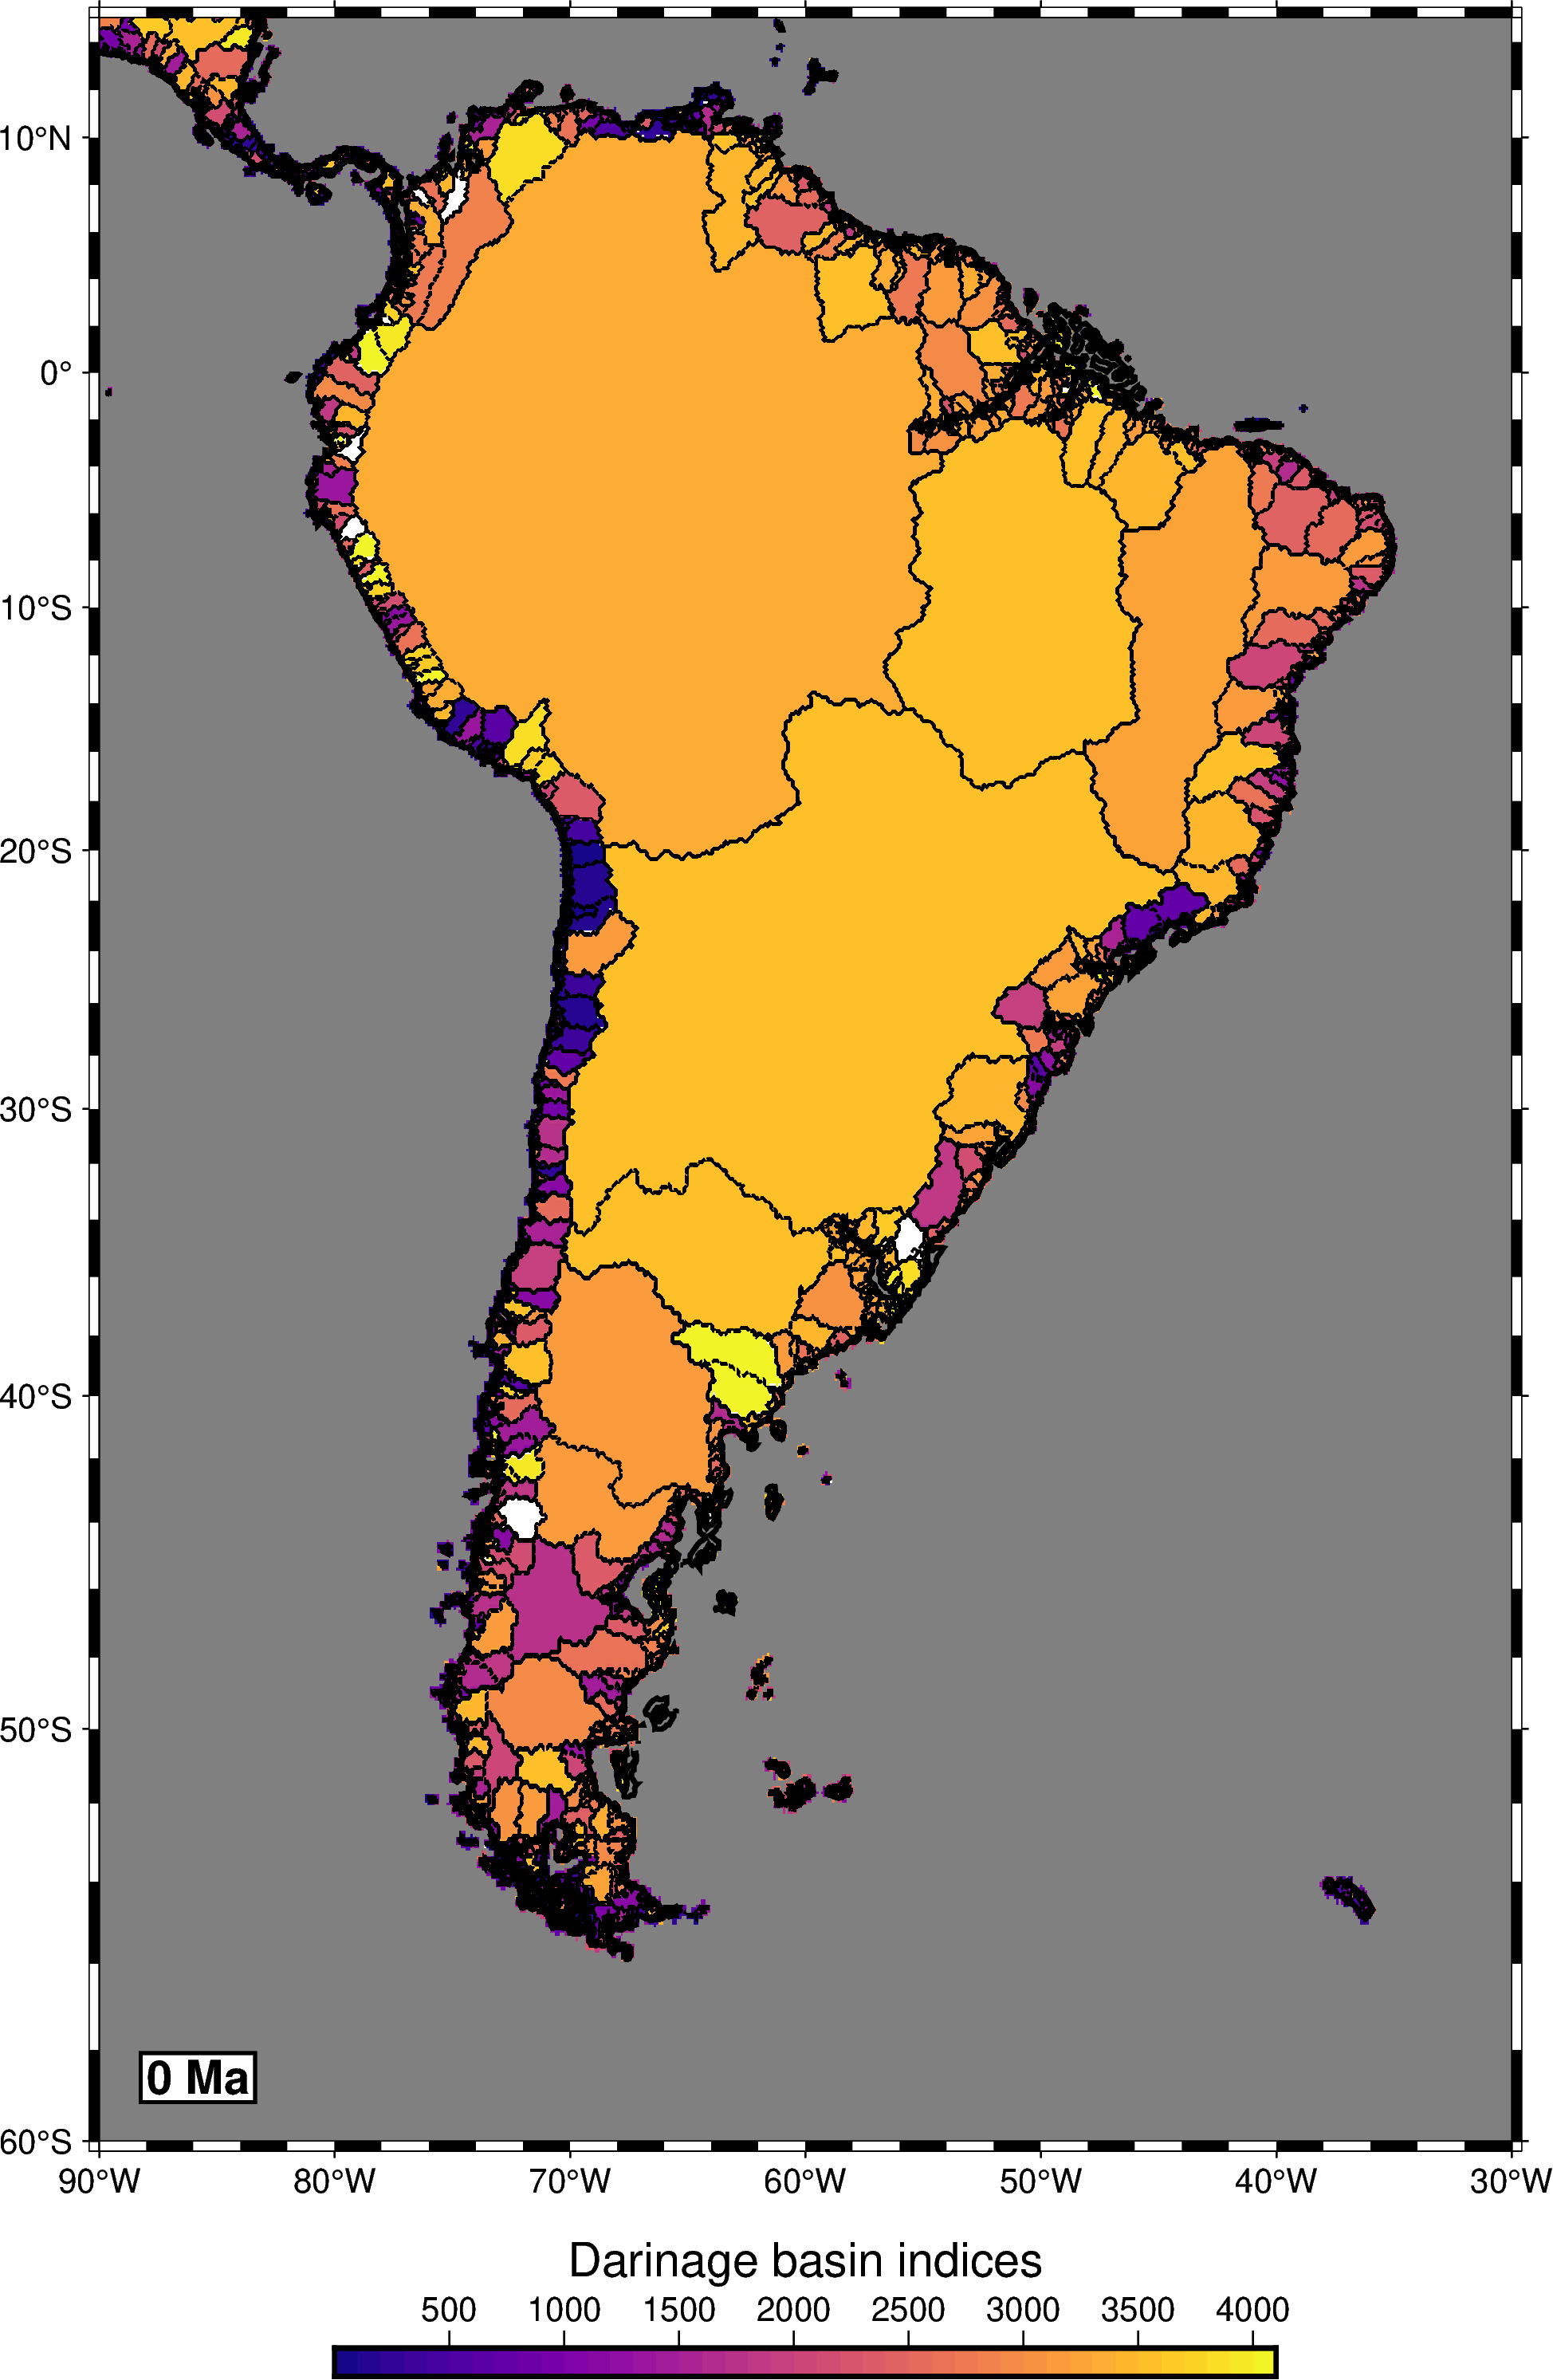

In [12]:
fig = pygmt.Figure()

with pygmt.config(COLOR_FOREGROUND="white", COLOR_BACKGROUND="white"):
    pygmt.makecpt(
        cmap="plasma", 
        series=[1,localBasinNb, 100],
    )
    
proj='M15c'



fig.grdimage(grid=clipds.newBasin,
             cmap=True,
             projection=proj,
             shading=False,
             frame=True,
            )

# Add contour
fig.grdcontour(
    interval=0.1,
    grid=clipds.elevation,
    projection=proj,
    limit=[-0.1, 0.1],
    pen = '1.5p'
)

# Add contour
fig.grdcontour(
    interval=1,
    grid=clipds.newBasin,
    region=region,
    projection=proj,
    limit=[0, 5000],
    pen = '0.25p,-'
)

fig.colorbar(frame=["a500", 'x+l"Darinage basin indices"'], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

# At time step
fig.text(text=str(step)+" Ma", position="BL", 
         fill='white', pen='1p', offset='0.5',
         font="14p,Helvetica-Bold,black",)

# name = 'SAbasin'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()